# Generative Adversarial Network

We will use Generative Adversarial Network code adapted from [Rowel Atienza](https://scholar.google.com.ph/citations?user=ZkpXaOsAAAAJ&hl=en) under MIT License to create sketches in the style of humans who have played the [Quick, Draw! game](https://quickdraw.withgoogle.com/) (data available here under Creative Commons Attribution 4.0 license). 

We will train on the [Quick, Draw! dataset](https://quickdraw.withgoogle.com/data), which are human-generated sketches from the Quick, Draw! game.

#### Load dependencies


In [1]:
import numpy as np
import os
import io
import requests

import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Activation, LeakyReLU
from tensorflow.keras.layers import Reshape 
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import Nadam

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

#### Load data

The NumPy bitmap files that we will be used for training can be found [here](https://console.cloud.google.com/storage/quickdraw_dataset/full/numpy_bitmap). For the purpose of this example we will be training the GAN to generate sketches of dogs.

In [2]:
response = requests.get('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/coffee%20cup.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content))
data.shape

(183432, 784)

The following shows the vector of one image in the training example, express as a greyscale image where each value is a pixel of the image from 0 to 255.

In [3]:
data[40]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   2,  83, 150, 169, 170, 170, 170, 185, 187,
       187, 187, 187, 138,  19,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  76, 214, 255, 230, 208, 204, 20

We will convert these pixels into a float value from 0 to 1 and reshape this as a 28x28 pixel to preview one of the images from the training set.

In [4]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1))
img_w, img_h = data.shape[1:3]
data.shape

(183432, 28, 28, 1)

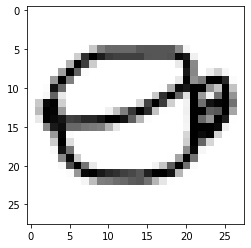

In [5]:
plt.imshow(data[40,:,:,0], cmap="Greys")

## Leaky ReLU

In [6]:
alpha = 0.05
leakyrelu = tensorflow.keras.layers.LeakyReLU(alpha=alpha)

## Discriminator Network


In [7]:
def build_discriminator(depth=64, p=0.4):
    # Input layer
    image = Input((img_w, img_h,1))
    
    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation=leakyrelu)(image)
    conv1 = Dropout(p)(conv1)
    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation=leakyrelu)(conv1)
    conv2 = Dropout(p)(conv2)
    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation=leakyrelu)(conv2)
    conv3 = Dropout(p)(conv3)
    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation=leakyrelu)(conv3)
    conv4 = Flatten()(Dropout(p)(conv4)) #
    
    # Output layer
    pred = Dense(1, activation='sigmoid')(conv4) # binary output of real vs fake
    
    # Model definition
    model = Model(inputs=image, outputs=pred)
    
    return model



In [8]:
# Creating an instance of the discriminator model
discriminator = build_discriminator()
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 256)         0     

In [9]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Nadam(lr=0.0008, clipvalue=1.0), 
                      metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


## Generator Network

In [10]:
z_dimensions = 32

In [11]:
def build_generator(latent_dim=z_dimensions, depth=64, p=0.4):
    
    # Define inputs
    noise = Input((latent_dim,))
    
    # First dense layer
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation=leakyrelu)(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation=leakyrelu)(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation=leakyrelu)(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation=leakyrelu)(conv3)

    # Output layer
    image = Conv2D(1, kernel_size=5, padding='same', 
                   activation='sigmoid')(conv3)

    # Model definition    
    model = Model(inputs=noise, outputs=image)
    
    return model

In [12]:
generator = build_generator()
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              103488    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 64)          0         
                                                           

## Adversarial Network

In [13]:
z = Input(shape=(z_dimensions,))
img = generator(z)
discriminator.trainable = False
pred = discriminator(img)
adversarial_model = Model(z, pred)

In [14]:
adversarial_model.compile(loss='binary_crossentropy', 
                          optimizer=Nadam(lr=0.0004, clipvalue=1.0), 
                          metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


## Training the network

In [15]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(1,epochs+1): 
        # sample real images: 
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        
        # generate fake images: 
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, z_dim]))
        
        # concatenate images as discriminator inputs:
        X = np.concatenate((real_imgs,fake_imgs))
        
        # assign y labels for discriminator: 
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        # train discriminator: 
        d_metrics.append(discriminator.train_on_batch(X,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        # adversarial net's noise input and "real" y: 
        noise = np.random.uniform(-1.0,1.0,size=[batch, z_dim])
        y = np.ones([batch,1])
        
        # train adversarial net: 
        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        # periodically print progress & fake images: 
        if i%100 == 0:
            print('Epoch #{}'.format(i))
            log_mesg = "%d: [Discriminator loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [Generator loss: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='Greys')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

Epoch #100
100: [Discriminator loss: 0.302402, acc: 0.942383]  [Generator loss: 1.646881, acc: 0.381719]


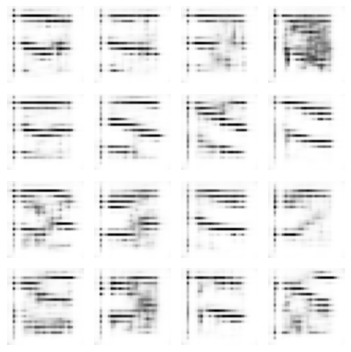

Epoch #200
200: [Discriminator loss: 0.248579, acc: 0.938184]  [Generator loss: 2.676030, acc: 0.221328]


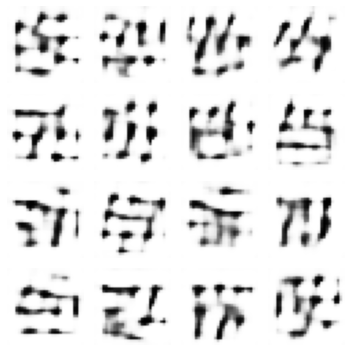

Epoch #300
300: [Discriminator loss: 0.251722, acc: 0.923867]  [Generator loss: 2.849429, acc: 0.180807]


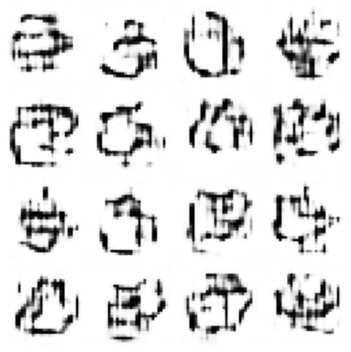

Epoch #400
400: [Discriminator loss: 0.265211, acc: 0.910410]  [Generator loss: 2.784795, acc: 0.163828]


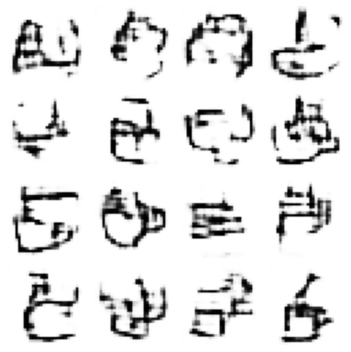

Epoch #500
500: [Discriminator loss: 0.283316, acc: 0.897523]  [Generator loss: 2.670863, acc: 0.155516]


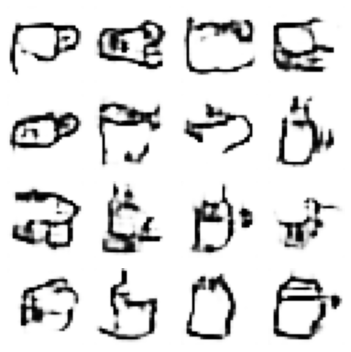

Epoch #600
600: [Discriminator loss: 0.296765, acc: 0.887650]  [Generator loss: 2.590176, acc: 0.150039]


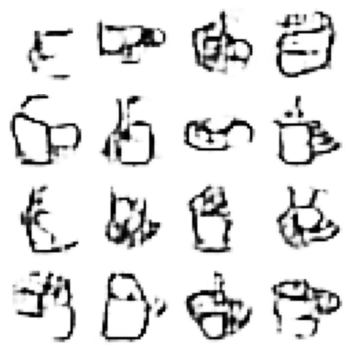

Epoch #700
700: [Discriminator loss: 0.305211, acc: 0.881295]  [Generator loss: 2.537939, acc: 0.144933]


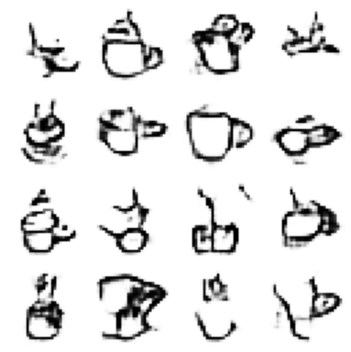

Epoch #800
800: [Discriminator loss: 0.312159, acc: 0.876172]  [Generator loss: 2.497936, acc: 0.140771]


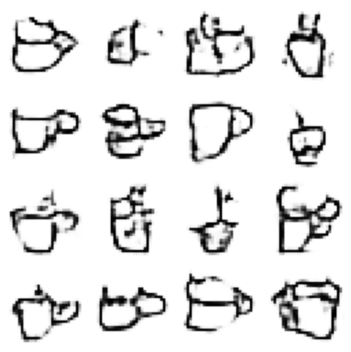

Epoch #900
900: [Discriminator loss: 0.317805, acc: 0.872318]  [Generator loss: 2.471229, acc: 0.137023]


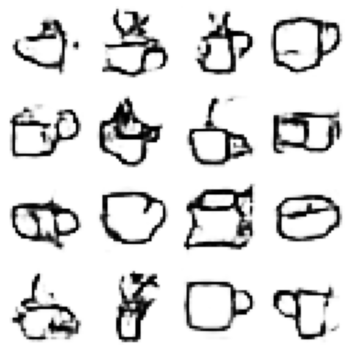

Epoch #1000
1000: [Discriminator loss: 0.321572, acc: 0.869492]  [Generator loss: 2.453010, acc: 0.134031]


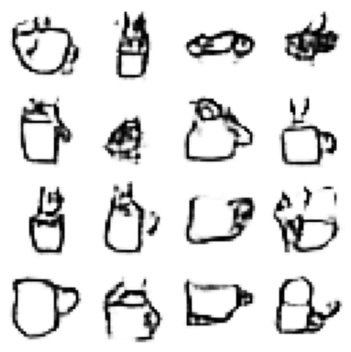

Epoch #1100
1100: [Discriminator loss: 0.323937, acc: 0.867450]  [Generator loss: 2.438434, acc: 0.131420]


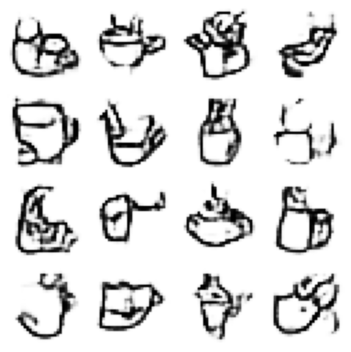

Epoch #1200
1200: [Discriminator loss: 0.326024, acc: 0.865661]  [Generator loss: 2.431447, acc: 0.128900]


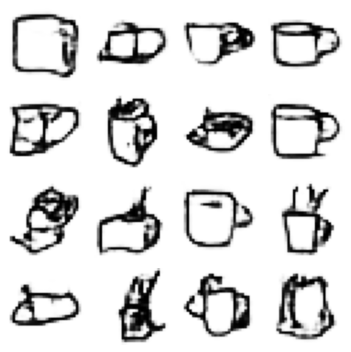

Epoch #1300
1300: [Discriminator loss: 0.326888, acc: 0.864660]  [Generator loss: 2.428420, acc: 0.126635]


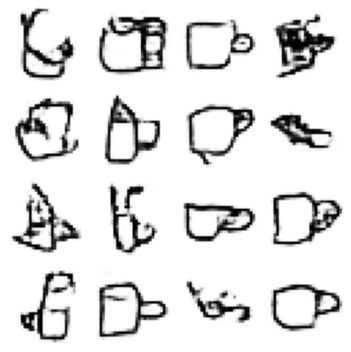

Epoch #1400
1400: [Discriminator loss: 0.327260, acc: 0.864068]  [Generator loss: 2.428997, acc: 0.124888]


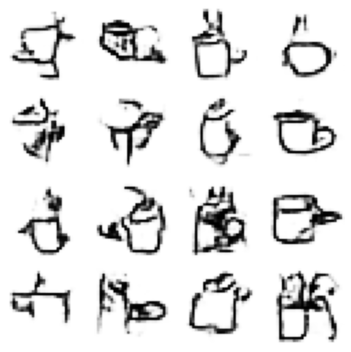

Epoch #1500
1500: [Discriminator loss: 0.327931, acc: 0.863242]  [Generator loss: 2.429924, acc: 0.123427]


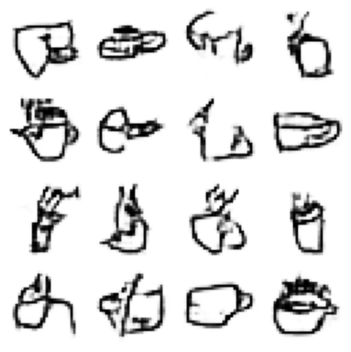

Epoch #1600
1600: [Discriminator loss: 0.327726, acc: 0.863005]  [Generator loss: 2.434308, acc: 0.121558]


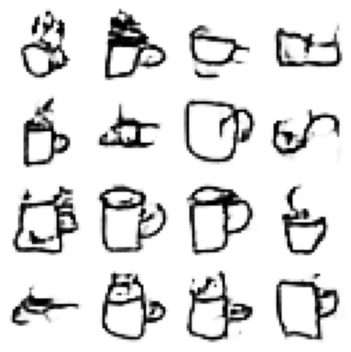

Epoch #1700
1700: [Discriminator loss: 0.327329, acc: 0.862941]  [Generator loss: 2.439758, acc: 0.120000]


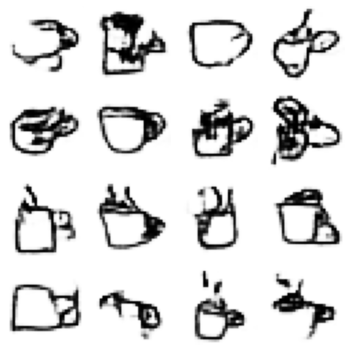

Epoch #1800
1800: [Discriminator loss: 0.326605, acc: 0.863034]  [Generator loss: 2.446859, acc: 0.118346]


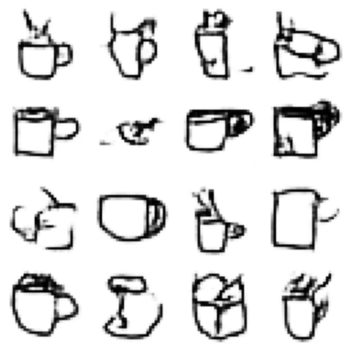

Epoch #1900
1900: [Discriminator loss: 0.325382, acc: 0.863347]  [Generator loss: 2.455007, acc: 0.116579]


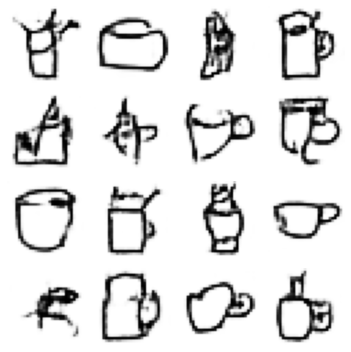

Epoch #2000
2000: [Discriminator loss: 0.324376, acc: 0.863656]  [Generator loss: 2.461482, acc: 0.115187]


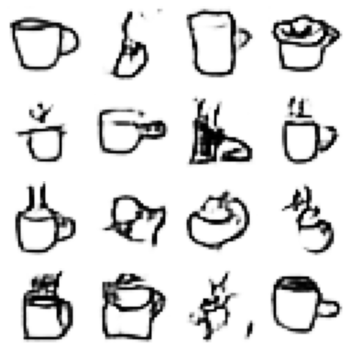

In [16]:
a_metrics_complete, d_metrics_complete = train()

### Plotting Training Loss


Text(0, 0.5, 'Loss')

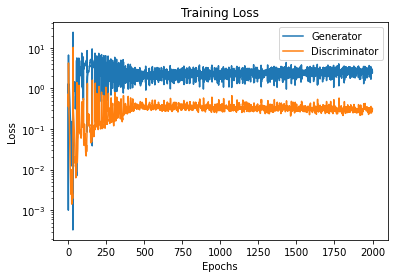

In [17]:
ax = pd.DataFrame(
    {'Generator': [metric[0] for metric in a_metrics_complete],
     'Discriminator': [metric[0] for metric in d_metrics_complete],}).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")